# 03 - Feature Selection & Importance Analysis
## Heart Disease UCI Dataset

### Objectives:
- Apply multiple feature selection techniques
- Use Random Forest and XGBoost for feature importance
- Implement Recursive Feature Elimination (RFE)
- Perform statistical feature selection (Chi-Square, Mutual Information)
- Compare and evaluate different feature selection methods
- Select optimal feature subset for modeling

## 1. Import Required Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Preprocessed Data

In [14]:
# Load the preprocessed data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(" Preprocessed data loaded successfully!")
print(f"   Training set: {X_train.shape}")
print(f"   Testing set: {X_test.shape}")
print(f"   Features: {list(X_train.columns)}")

# Display feature information
print("\n Feature Names:")
for i, feature in enumerate(X_train.columns, 1):
    print(f"   {i:2d}. {feature}")

 Preprocessed data loaded successfully!
   Training set: (736, 13)
   Testing set: (184, 13)
   Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

 Feature Names:
    1. age
    2. sex
    3. cp
    4. trestbps
    5. chol
    6. fbs
    7. restecg
    8. thalach
    9. exang
   10. oldpeak
   11. slope
   12. ca
   13. thal


## 3. Method 1: Feature Importance with Random Forest

=== RANDOM FOREST FEATURE IMPORTANCE ===

Random Forest Feature Importance Ranking:
    1. age        : 0.1492
    2. chol       : 0.1385
    3. thalach    : 0.1351
    4. oldpeak    : 0.1161
    5. trestbps   : 0.1071
    6. cp         : 0.0941
    7. exang      : 0.0508
    8. thal       : 0.0442
    9. restecg    : 0.0421
   10. ca         : 0.0392
   11. slope      : 0.0347
   12. sex        : 0.0254
   13. fbs        : 0.0235


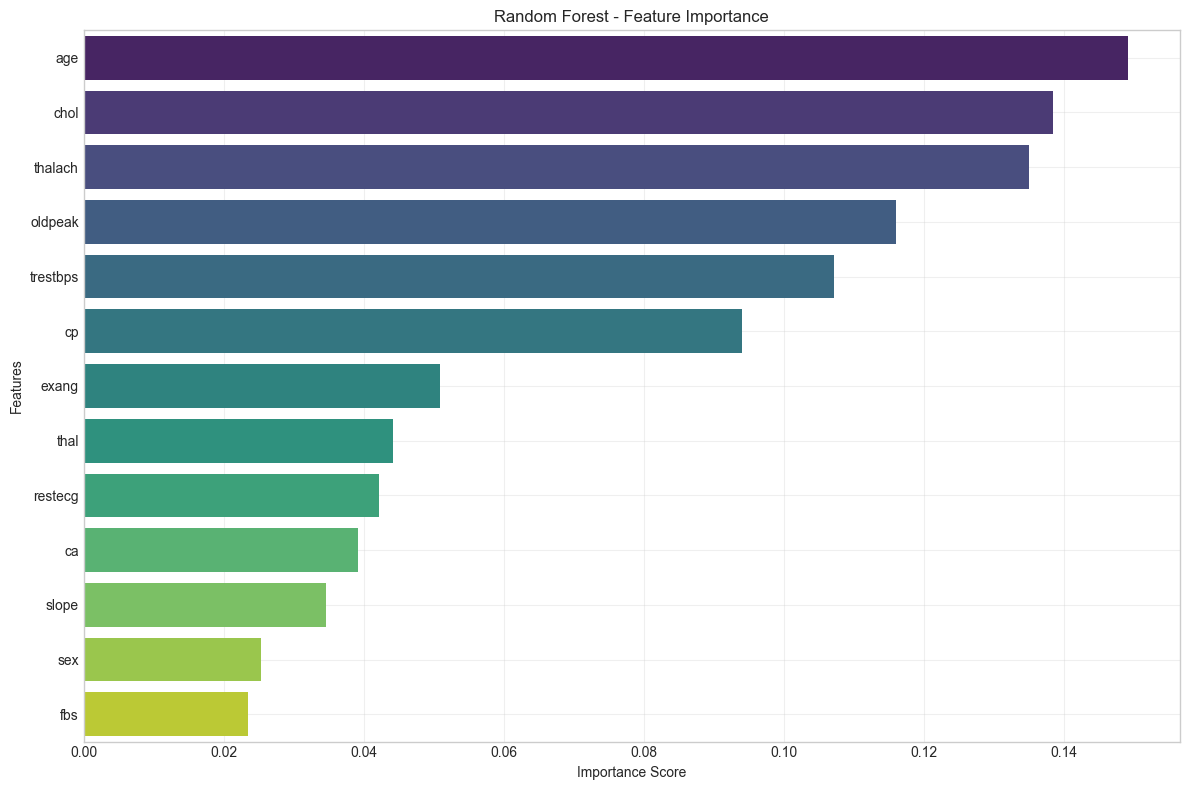

In [15]:
print("=== RANDOM FOREST FEATURE IMPORTANCE ===\n")

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances
rf_importances = rf.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance Ranking:")
for i, (_, row) in enumerate(rf_feature_importance_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:10} : {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=rf_feature_importance_df, x='importance', y='feature', palette='viridis')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Method 2: Feature Importance with XGBoost

=== XGBOOST FEATURE IMPORTANCE ===

XGBoost Feature Importance Ranking:
    1. cp         : 0.2149
    2. sex        : 0.1346
    3. ca         : 0.0902
    4. thal       : 0.0684
    5. exang      : 0.0658
    6. slope      : 0.0630
    7. oldpeak    : 0.0624
    8. fbs        : 0.0588
    9. chol       : 0.0573
   10. age        : 0.0531
   11. thalach    : 0.0503
   12. trestbps   : 0.0415
   13. restecg    : 0.0397


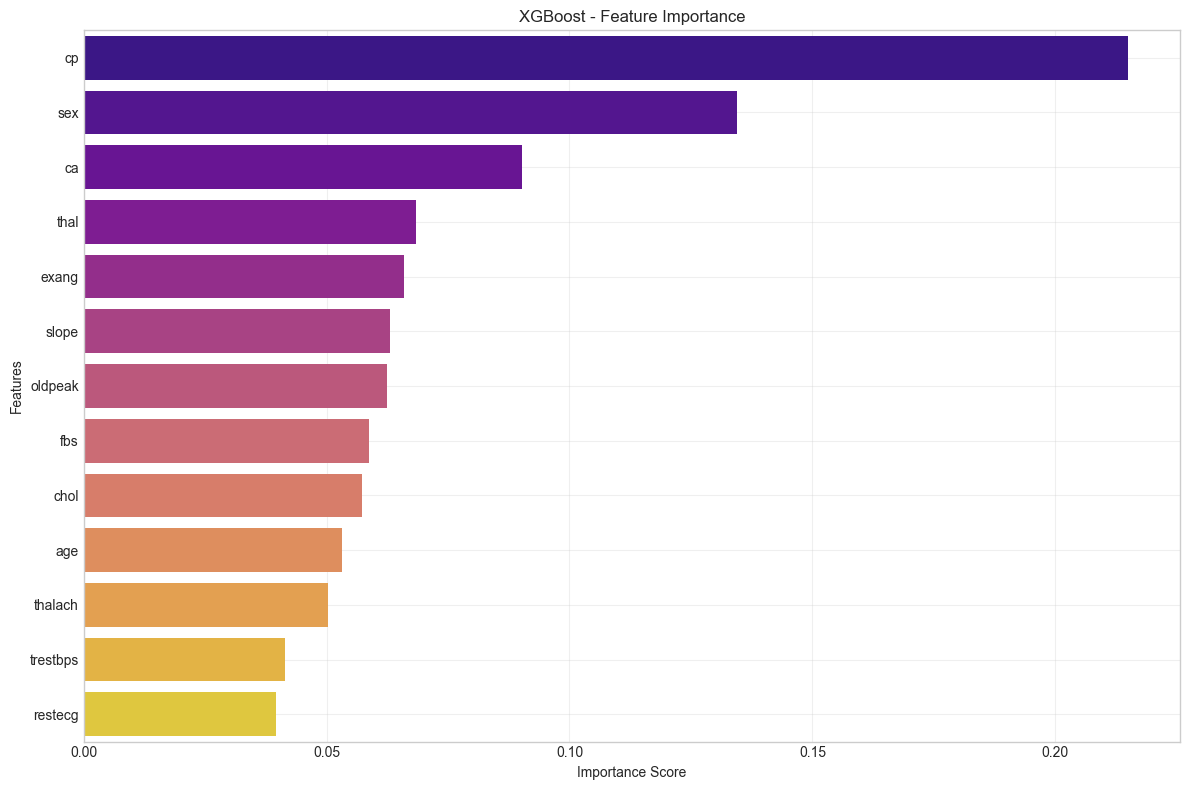

In [16]:
print("=== XGBOOST FEATURE IMPORTANCE ===\n")

# Train XGBoost classifier
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

# Get feature importances
xgb_importances = xgb.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_importances
}).sort_values('importance', ascending=False)

print("XGBoost Feature Importance Ranking:")
for i, (_, row) in enumerate(xgb_feature_importance_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:10} : {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=xgb_feature_importance_df, x='importance', y='feature', palette='plasma')
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Method 3: Recursive Feature Elimination (RFE)

=== RECURSIVE FEATURE ELIMINATION (RFE) ===

RFE Feature Ranking (1 = selected):
    1. age        : Ranking 1
    2. sex        : Ranking 1
    3. cp         : Ranking 1
    4. chol       : Ranking 1
    5. thalach    : Ranking 1
    6. restecg    : Ranking 1
    7. ca         : Ranking 1
    8. oldpeak    : Ranking 1
    9. fbs        : Ranking 2
   10. thal       : Ranking 3
   11. exang      : Ranking 4
   12. slope      : Ranking 5
   13. trestbps   : Ranking 6

 Selected 8 features: ['age', 'sex', 'cp', 'chol', 'restecg', 'thalach', 'oldpeak', 'ca']


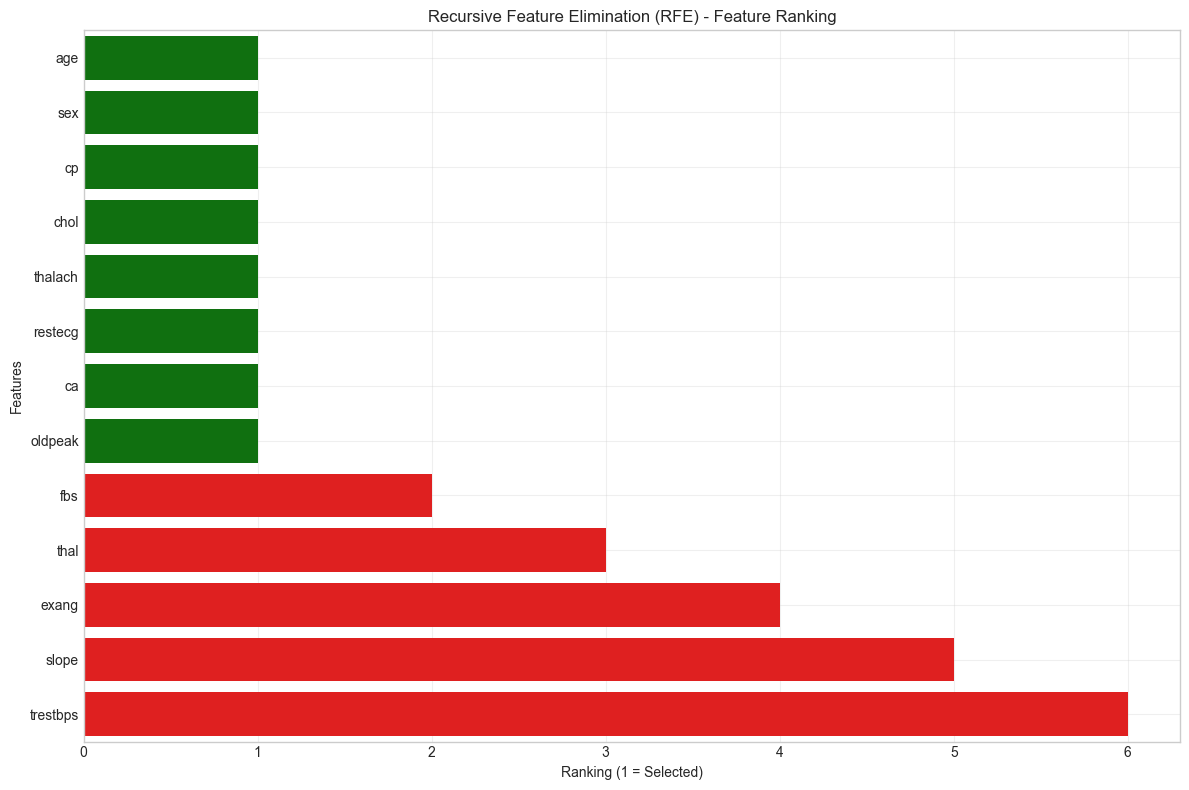

In [17]:
print("=== RECURSIVE FEATURE ELIMINATION (RFE) ===\n")

# Use Logistic Regression as estimator for RFE
estimator = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')

# Apply RFE to select top 8 features
rfe_selector = RFE(estimator=estimator, n_features_to_select=8, step=1)
rfe_selector.fit(X_train, y_train)

# Get selected features
rfe_selected_features = X_train.columns[rfe_selector.support_].tolist()
rfe_ranking = rfe_selector.ranking_

# Create ranking DataFrame
rfe_ranking_df = pd.DataFrame({
    'feature': X_train.columns,
    'ranking': rfe_ranking
}).sort_values('ranking')

print("RFE Feature Ranking (1 = selected):")
for i, (_, row) in enumerate(rfe_ranking_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:10} : Ranking {row['ranking']}")

print(f"\n Selected {len(rfe_selected_features)} features: {rfe_selected_features}")

# Visualize RFE ranking
plt.figure(figsize=(12, 8))
colors = ['green' if rank == 1 else 'red' for rank in rfe_ranking_df['ranking']]
sns.barplot(data=rfe_ranking_df, x='ranking', y='feature', palette=colors)
plt.title('Recursive Feature Elimination (RFE) - Feature Ranking')
plt.xlabel('Ranking (1 = Selected)')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== RFE WITH CROSS-VALIDATION ===

Optimal number of features: 12
Selected features: ['age', 'sex', 'cp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


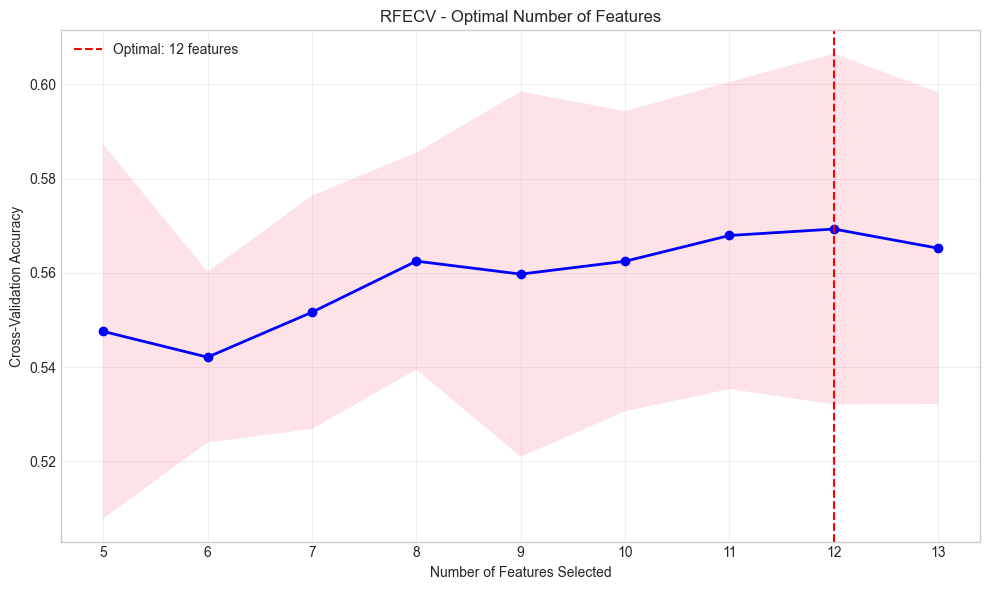

In [18]:
# Advanced: RFE with Cross-Validation
print("=== RFE WITH CROSS-VALIDATION ===\n")

rfecv_selector = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    min_features_to_select=5,
    n_jobs=-1
)

rfecv_selector.fit(X_train, y_train)

# Get optimal number of features
optimal_features = rfecv_selector.n_features_
rfecv_selected_features = X_train.columns[rfecv_selector.support_].tolist()

print(f"Optimal number of features: {optimal_features}")
print(f"Selected features: {rfecv_selected_features}")

# Plot RFECV results
plt.figure(figsize=(10, 6))
plt.plot(range(5, len(rfecv_selector.cv_results_['mean_test_score']) + 5), 
         rfecv_selector.cv_results_['mean_test_score'], 'b-', marker='o', linewidth=2)
plt.fill_between(range(5, len(rfecv_selector.cv_results_['mean_test_score']) + 5),
                 rfecv_selector.cv_results_['mean_test_score'] - rfecv_selector.cv_results_['std_test_score'],
                 rfecv_selector.cv_results_['mean_test_score'] + rfecv_selector.cv_results_['std_test_score'],
                 alpha=0.2)
plt.axvline(x=optimal_features, color='r', linestyle='--', label=f'Optimal: {optimal_features} features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.title('RFECV - Optimal Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Method 4: Statistical Feature Selection

In [19]:
print("=== STATISTICAL FEATURE SELECTION ===\n")

# 6.1 Chi-Square Test (for categorical features)
# Note: Since our data is scaled, we need to transform it for chi2
from sklearn.preprocessing import MinMaxScaler

# Scale features to non-negative for chi2
scaler_minmax = MinMaxScaler()
X_train_non_negative = scaler_minmax.fit_transform(X_train)

# Apply Chi-Square test
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_train_non_negative, y_train)

chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# 6.2 Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_train, y_train)
mi_scores = mi_selector.scores_

# Create statistical scores DataFrame
statistical_scores_df = pd.DataFrame({
    'feature': X_train.columns,
    'chi2_score': chi2_scores,
    'chi2_pvalue': chi2_pvalues,
    'mutual_info': mi_scores
})

# Sort by mutual information (most relevant)
statistical_scores_df = statistical_scores_df.sort_values('mutual_info', ascending=False)

print("Statistical Feature Scores:")
print("Feature           | Chi2 Score  | Chi2 P-value | Mutual Info")
print("-" * 60)
for _, row in statistical_scores_df.iterrows():
    print(f"{row['feature']:15} | {row['chi2_score']:10.2f} | {row['chi2_pvalue']:11.4f} | {row['mutual_info']:10.4f}")

# Identify significant features (p-value < 0.05)
significant_features = statistical_scores_df[statistical_scores_df['chi2_pvalue'] < 0.05]['feature'].tolist()
print(f"\n Statistically significant features (p < 0.05): {significant_features}")

=== STATISTICAL FEATURE SELECTION ===

Statistical Feature Scores:
Feature           | Chi2 Score  | Chi2 P-value | Mutual Info
------------------------------------------------------------
cp              |      19.50 |      0.0006 |     0.0912
oldpeak         |       4.81 |      0.3072 |     0.0898
thalach         |       6.67 |      0.1546 |     0.0864
sex             |      14.10 |      0.0070 |     0.0605
chol            |       6.45 |      0.1682 |     0.0589
exang           |      79.23 |      0.0000 |     0.0506
thal            |      55.69 |      0.0000 |     0.0460
slope           |       5.20 |      0.2671 |     0.0374
age             |       6.52 |      0.1637 |     0.0316
fbs             |      19.37 |      0.0007 |     0.0314
trestbps        |       0.09 |      0.9990 |     0.0119
restecg         |      10.74 |      0.0296 |     0.0000
ca              |      39.87 |      0.0000 |     0.0000

 Statistically significant features (p < 0.05): ['cp', 'sex', 'exang', 'thal', 'fb

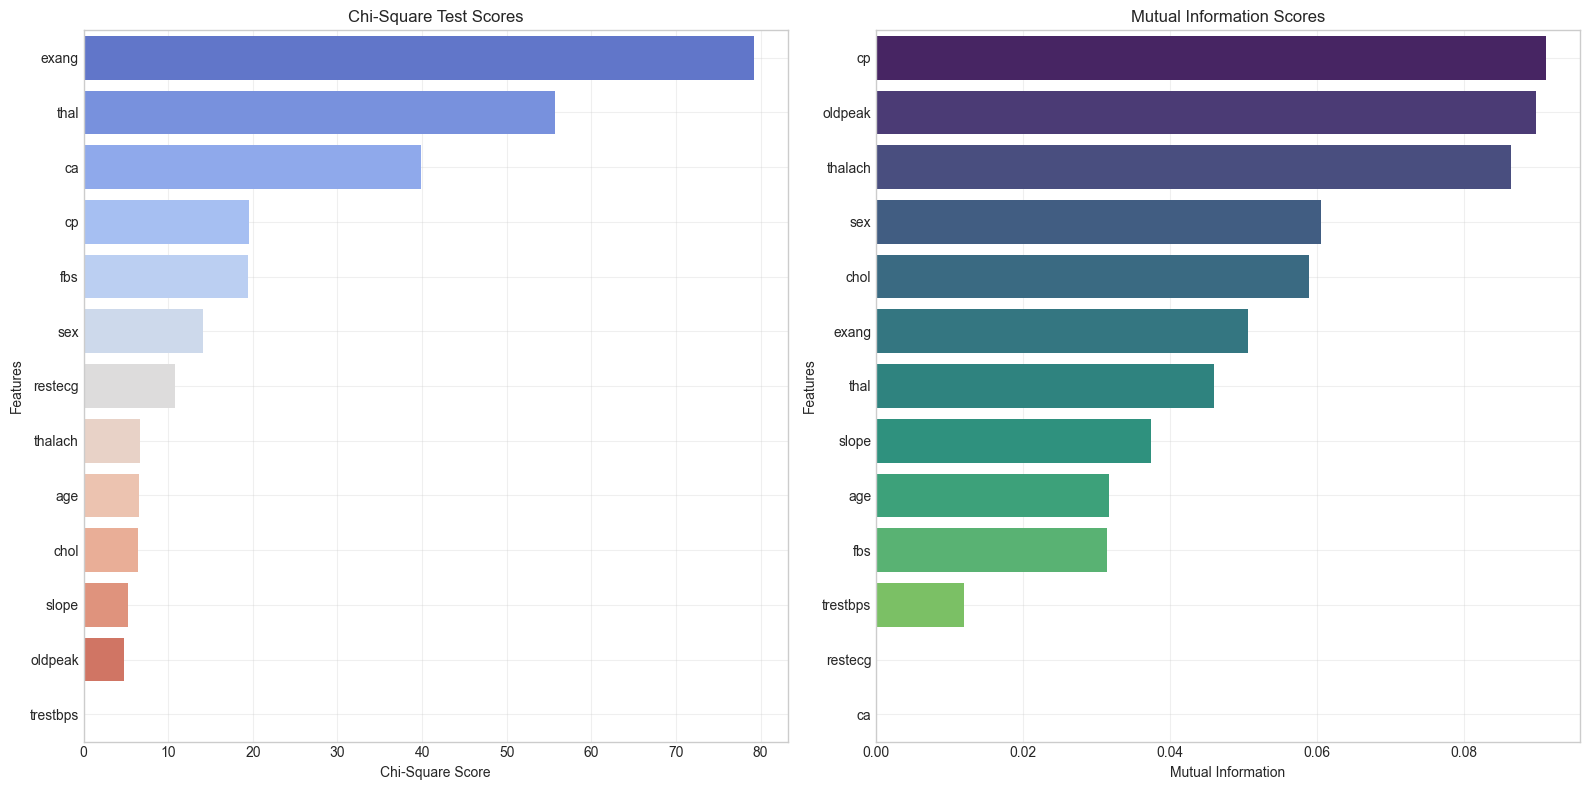

In [20]:
# Visualize statistical scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Chi-Square scores
chi2_df = statistical_scores_df.sort_values('chi2_score', ascending=False)
sns.barplot(data=chi2_df, x='chi2_score', y='feature', ax=ax1, palette='coolwarm')
ax1.set_title('Chi-Square Test Scores')
ax1.set_xlabel('Chi-Square Score')
ax1.set_ylabel('Features')
ax1.grid(True, alpha=0.3)

# Mutual Information scores
mi_df = statistical_scores_df.sort_values('mutual_info', ascending=False)
sns.barplot(data=mi_df, x='mutual_info', y='feature', ax=ax2, palette='viridis')
ax2.set_title('Mutual Information Scores')
ax2.set_xlabel('Mutual Information')
ax2.set_ylabel('Features')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Comparative Analysis of Feature Selection Methods

In [21]:
print("=== COMPARATIVE FEATURE SELECTION ANALYSIS ===\n")

# Create a comprehensive feature ranking system
feature_scores = {}

# Initialize scores for all features
for feature in X_train.columns:
    feature_scores[feature] = 0

# Add scores from each method
methods = [
    ('Random Forest', rf_feature_importance_df),
    ('XGBoost', xgb_feature_importance_df),
    ('Mutual Info', statistical_scores_df[['feature', 'mutual_info']]),
    ('Chi-Square', statistical_scores_df[['feature', 'chi2_score']].rename(columns={'chi2_score': 'score'}))
]

for method_name, df in methods:
    # Get the score column name
    score_col = 'importance' if 'importance' in df.columns else 'mutual_info' if 'mutual_info' in df.columns else 'score'
    
    # Normalize scores to 0-1 range
    normalized_scores = (df[score_col] - df[score_col].min()) / (df[score_col].max() - df[score_col].min())
    
    # Add to feature scores
    for i, feature in enumerate(df['feature']):
        feature_scores[feature] += normalized_scores.iloc[i]

# Create final ranking
final_ranking_df = pd.DataFrame({
    'feature': list(feature_scores.keys()),
    'composite_score': list(feature_scores.values())
}).sort_values('composite_score', ascending=False)

print("Composite Feature Ranking (Combined Methods):")
for i, (_, row) in enumerate(final_ranking_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:10} : {row['composite_score']:.4f}")

# Select top features based on composite score
top_n_features = 8
selected_features_final = final_ranking_df.head(top_n_features)['feature'].tolist()

print(f"\n FINAL SELECTED FEATURES ({top_n_features}): {selected_features_final}")

=== COMPARATIVE FEATURE SELECTION ANALYSIS ===

Composite Feature Ranking (Combined Methods):
    1. cp         : 2.8069
    2. thalach    : 1.9792
    3. exang      : 1.9215
    4. oldpeak    : 1.9108
    5. chol       : 1.7425
    6. thal       : 1.5348
    7. age        : 1.5043
    8. sex        : 1.3968
    9. ca         : 0.9160
   10. trestbps   : 0.8066
   11. fbs        : 0.6969
   12. slope      : 0.6966
   13. restecg    : 0.2831

 FINAL SELECTED FEATURES (8): ['cp', 'thalach', 'exang', 'oldpeak', 'chol', 'thal', 'age', 'sex']


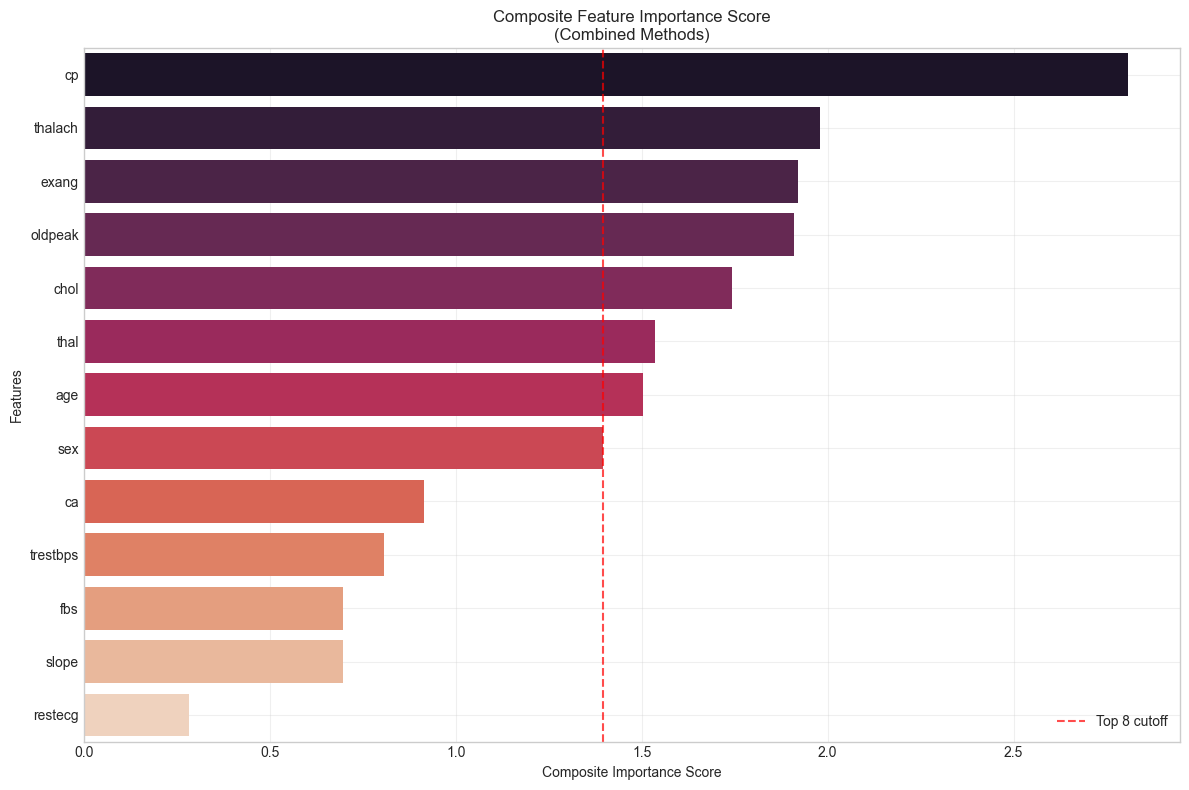

In [22]:
# Visualize composite ranking
plt.figure(figsize=(12, 8))
sns.barplot(data=final_ranking_df, x='composite_score', y='feature', palette='rocket')
plt.axvline(x=final_ranking_df['composite_score'].iloc[top_n_features-1], 
            color='red', linestyle='--', alpha=0.7, label=f'Top {top_n_features} cutoff')
plt.title('Composite Feature Importance Score\n(Combined Methods)')
plt.xlabel('Composite Importance Score')
plt.ylabel('Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluate Selected Feature Subset

=== FEATURE SUBSET EVALUATION ===

Feature Selection Method Comparison:
--------------------------------------------------------------------------------
Composite Top 8      |  8 features | Accuracy: 0.5761 ± 0.0200
Random Forest Top 8  |  8 features | Accuracy: 0.5667 ± 0.0388
All Features         | 13 features | Accuracy: 0.5666 ± 0.0295
RFE Selected         |  8 features | Accuracy: 0.5462 ± 0.0243
XGBoost Top 8        |  8 features | Accuracy: 0.5272 ± 0.0438
Statistical Significant |  7 features | Accuracy: 0.5232 ± 0.0566


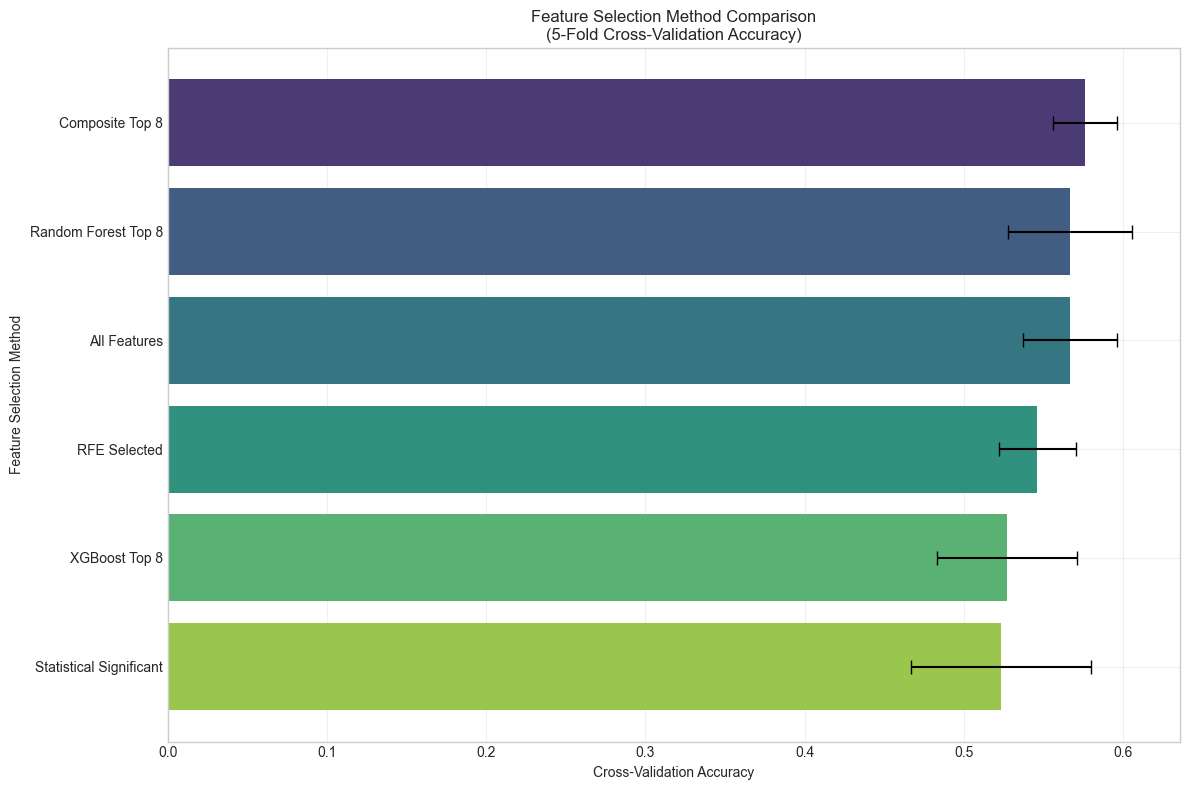

In [23]:
print("=== FEATURE SUBSET EVALUATION ===\n")

# Create subsets with different feature selection methods
feature_subsets = {
    'All Features': X_train.columns.tolist(),
    'Random Forest Top 8': rf_feature_importance_df.head(8)['feature'].tolist(),
    'XGBoost Top 8': xgb_feature_importance_df.head(8)['feature'].tolist(),
    'RFE Selected': rfe_selected_features,
    'Statistical Significant': significant_features,
    'Composite Top 8': selected_features_final
}

# Evaluate each subset using cross-validation
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for method_name, features in feature_subsets.items():
    if len(features) == 0:
        continue
        
    X_subset = X_train[features]
    
    # Use Random Forest for evaluation
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_subset, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    results.append({
        'Method': method_name,
        'Num_Features': len(features),
        'CV_Accuracy_Mean': cv_scores.mean(),
        'CV_Accuracy_Std': cv_scores.std(),
        'Features': features
    })

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('CV_Accuracy_Mean', ascending=False)

print("Feature Selection Method Comparison:")
print("-" * 80)
for _, row in results_df.iterrows():
    print(f"{row['Method']:20} | {row['Num_Features']:2d} features | Accuracy: {row['CV_Accuracy_Mean']:.4f} ± {row['CV_Accuracy_Std']:.4f}")

# Visualize comparison
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='CV_Accuracy_Mean', y='Method', palette='viridis')
plt.errorbar(x=results_df['CV_Accuracy_Mean'], y=range(len(results_df)), 
             xerr=results_df['CV_Accuracy_Std'], fmt='none', c='black', capsize=5)
plt.title('Feature Selection Method Comparison\n(5-Fold Cross-Validation Accuracy)')
plt.xlabel('Cross-Validation Accuracy')
plt.ylabel('Feature Selection Method')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Feature Selection Results

In [24]:
print("=== SAVING FEATURE SELECTION RESULTS ===\n")

# Select the best performing feature subset
best_method = results_df.iloc[0]
selected_features = best_method['Features']

print(f" BEST PERFORMING METHOD: {best_method['Method']}")
print(f"   Features: {selected_features}")
print(f"   Cross-Validation Accuracy: {best_method['CV_Accuracy_Mean']:.4f} ± {best_method['CV_Accuracy_Std']:.4f}")

# Save selected features
selected_features_df = pd.DataFrame({'selected_features': selected_features})
selected_features_df.to_csv('../data/selected_features.csv', index=False)

# Create datasets with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.to_csv('../data/X_train_selected.csv', index=False)
X_test_selected.to_csv('../data/X_test_selected.csv', index=False)

# Save all feature importance results
rf_feature_importance_df.to_csv('../results/rf_feature_importance.csv', index=False)
xgb_feature_importance_df.to_csv('../results/xgb_feature_importance.csv', index=False)
rfe_ranking_df.to_csv('../results/rfe_ranking.csv', index=False)
statistical_scores_df.to_csv('../results/statistical_scores.csv', index=False)
final_ranking_df.to_csv('../results/composite_feature_ranking.csv', index=False)
results_df.to_csv('../results/feature_selection_comparison.csv', index=False)

print("\n Feature selection results saved successfully!")
print("   - selected_features.csv: Final selected features")
print("   - X_train_selected.csv: Training data with selected features")
print("   - X_test_selected.csv: Testing data with selected features")
print("   - Various analysis files in results/ folder")

print(f"\n Feature Selection Summary:")
print(f"   Original features: {X_train.shape[1]}")
print(f"   Selected features: {len(selected_features)}")
print(f"   Feature reduction: {(1 - len(selected_features)/X_train.shape[1]):.1%}")
print(f"   Best method: {best_method['Method']}")



=== SAVING FEATURE SELECTION RESULTS ===

 BEST PERFORMING METHOD: Composite Top 8
   Features: ['cp', 'thalach', 'exang', 'oldpeak', 'chol', 'thal', 'age', 'sex']
   Cross-Validation Accuracy: 0.5761 ± 0.0200

 Feature selection results saved successfully!
   - selected_features.csv: Final selected features
   - X_train_selected.csv: Training data with selected features
   - X_test_selected.csv: Testing data with selected features
   - Various analysis files in results/ folder

 Feature Selection Summary:
   Original features: 13
   Selected features: 8
   Feature reduction: 38.5%
   Best method: Composite Top 8
